# UCLA-CRM time and spatial averaging
Anna Mackie, 2022

Processing for long channel simulations from CM1. Three SSTs (295, 300 and 305K). Please see Wing et al. (2018) for simulation and variable descriptions.

This script, for different data:
- reads in data from CEDA archive
- takes the average over 24 hours and 32 x 32 grid points (equivilent to 96 km x 96km). NB last blocks may have more grid points to ensure all grid points used
- saves as npy files

This is done for a number of variables. The code is grouped for
1. 2D variables
2. 3D variables
3. Cloud fraction

Cloud fraction follows the method of Wing et al., (2020) which uses a threshold value for cloud condensate.

In [1]:
# activate virtual environmnet required for metpy
import sys
import pathlib
import platform
venv_path = '~/nb-venvs/metpy_venv'
sys.path.append(str(pathlib.Path(f'{venv_path}/lib/python{platform.python_version_tuple()[0]}.{platform.python_version_tuple()[1]}/site-packages/').expanduser()))

import metpy
print(metpy.__file__)

/home/users/arm33/nb-venvs/metpy_venv/lib/python3.10/site-packages/metpy/__init__.py


In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from metpy.calc import saturation_mixing_ratio
from metpy.units import units
import numpy.ma as ma
import os
import sys
sys.path.append('../../')
import funcs



## Model specific inputs
Different models have slightly different set ups (eg grid points, file names etc)

'Blocks' refer to the grid post-spatial averaging

In [3]:
model = 'UCLA-CRM' #in this model, time is in hours, with 24 hours to a file

#temp labels
temps =  ['large295', 'large300', 'large305']

In [4]:
#read in sample nc file to get dimensions
datapath3D = '/badc/rcemip/data/'+ model +'/RCE_' + temps[0]+ '/3D/'
nc_ta = Dataset(datapath3D + model + '_RCE_' + temps[0] + '_3D_ta.nc')
ta = nc_ta.variables['ta'][:]
tsize, ysize, xsize,levsize = np.shape(ta) # UCLA has levels in 4th dimension
nc_ta.close()
print(tsize, levsize, ysize, xsize)


101 128 1984 75


In [ ]:
#set time, levels, x and y dimensions
tsize, ysize, xsize, levsize = 101, 128, 1984, 75 # levels in 4th dimension!!

## Parameters for all models

In [4]:
bk = 32 # number of x/y gridpoints in a block
nodays = 25 # number of days


In [5]:
x = np.arange(xsize) # total number of x points (rows)
y = np.arange(ysize) # total number of y points (columns)
ny = int(len(y)/bk) # number of x/y blocks in the grid
nx = int(len(x)/bk)
xbk = np.asarray(np.split(x, nx))
ybk = np.asarray(np.split(y, ny))

print('no blocks in x direction: ', nx, '; no in y direction: ',ny)

no blocks in x direction:  62 ; no in y direction:  4


## 2D data

- lwcrf - longwave cloud radiative effect, calculated from rlut (outgoing longwave radiation, all sky) and rlutcs (clear sky)
- swcrf - as above, but for shortwave
- pr - surface precipitation rate
- tas - near surface air temperature

In [6]:
#time params for 2D data
#set time params
ts = 24 # number of hours want to integrate over
nd = int(nodays*ts)
totalt = np.arange(nd)# total number of hours 
tbk = np.asarray(np.split(totalt, nodays))
print('takes the average over ' + str(nodays) + ' periods of ' + str(ts)+ ' hour averages')    

takes the average over 25 periods of 24 hour averages


In [7]:
dp = '/home/users/arm33/RCEMIP/'+ model + '/processed_new'

for temp in temps:
    datapath = '/badc/rcemip/data/'+ model +'/RCE_' + temp + '/2D/'
    print('--------' + temp + '--------')
    
    nc = Dataset( datapath + model + '_RCE_' + temp + '_2D_rlut.nc') 
    lwas_full = nc.variables['rlut'][-nd:,]
    nc.close()
    nc =  Dataset( datapath + model + '_RCE_' + temp + '_2D_rlutcs.nc')
    lwcs_full = nc.variables['rlutcs'][-nd:,]
    nc.close()
    nc = Dataset( datapath + model + '_RCE_' + temp + '_2D_rsut.nc')
    swas_full = nc.variables['rsut'][-nd:,]
    nc.close()
    nc = Dataset( datapath + model + '_RCE_' + temp + '_2D_rsutcs.nc')
    swcs_full = nc.variables['rsutcs'][-nd:,]
    nc.close()
    
    lwcrf_full = lwcs_full - lwas_full
    swcrf_full = swcs_full - swas_full
    
    nc = Dataset( datapath + model + '_RCE_' + temp + '_2D_pr.nc') 
    pr_full = nc.variables['pr'][-nd:,]
    nc.close()
    lwcrf_bk, swcrf_bk= np.empty((nodays, ny, nx)), np.empty((nodays, ny, nx)) # crf
    pr_bk= np.empty((nodays, ny, nx))
    
    for t in range(nodays):
        for i in range(ny):
            for j in range(nx):
                lwcrf_bk[t, i, j] = np.nanmean(lwcrf_full[tbk[t,0]:tbk[t, -1]+1, ybk[i,0]:ybk[i,-1]+1, xbk[j,0]: xbk[j,-1]+1])
                swcrf_bk[t, i, j] = np.nanmean(swcrf_full[tbk[t,0]:tbk[t, -1]+1, ybk[i,0]:ybk[i,-1]+1, xbk[j,0]: xbk[j,-1]+1])
                pr_bk[t, i, j] = np.nanmean(pr_full[tbk[t,0]:tbk[t, -1]+1, ybk[i,0]:ybk[i,-1]+1, xbk[j,0]: xbk[j,-1]+1])
   

    lwcrf_bk.dump(dp + '/2D/'+ temp + 'lwcrf' + str(ts) + 'hrs.npy')
    swcrf_bk.dump(dp + '/2D/'+ temp + 'swcrf' + str(ts) + 'hrs.npy')
    pr_bk.dump(dp + '/2D/'+ temp + 'pr' + str(ts) + 'hrs.npy')
    
   
        
    print('Finished ' + temp)

--------large295--------
Finished large295
--------large300--------
Finished large300
--------large305--------
Finished large305


## 3D data

Note that the 3D data is 6 hourly, so require different time parameters

- ua - eastward wind velocity
- va - northward wind velocity
- wa - vertical velocity
- pa - pressure
- cli - mass fraction of cloud liqid ice
- clw - mass fraction of cloud liquid water
- hus - specific humidity
- hur - relative humidity
- tntr - tendency of air temperature due to radiative heating
- ta - atmospheric temperature

In [11]:
#time params for 3D data
ts = 4 # number of timesteps want to integrate over
nd = int(nodays*ts)
totalt = np.arange(nd)# total number of timesteps 
tbk = np.asarray(np.split(totalt, nodays))
print('takes the average over ' + str(nodays) + ' periods of ' + str(ts)+ ' hour averages')    

takes the average over 25 periods of 4 hour averages


In [29]:
vars = ['ua', 'va', 'pa','ice', 'clw','wa','hus','hur', 'tntr', 'ta']

dp = '/home/users/arm33/RCEMIP/'+ model + '/processed_new'

for temp in temps:

    datapath = '/badc/rcemip/data/'+ model +'/RCE_' + temp + '/3D/'
    for var in vars:
        print(var)
        
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_' + var + '.nc', 'r')
        
        var_bk = np.empty((nodays, ny, nx, levsize))
            
        for t in range(nodays):            
            var_full = np.nanmean(np.copy(nc.variables[var][tbk[t,0]:tbk[t,-1]+1,]), axis  = 0)
            for i in range(ny):
                for j in range(nx):
                    for k in range(levsize):
                        var_bk[t,i,j,k] = np.nanmean(var_full[ybk[i,0]:ybk[i,-1]+1, xbk[j,0]: xbk[j,-1]+1, k])
        var_bk.dump(dp + '/3D/' + temp + var + '_profile_25d.npy')
    
        print('Finished ' + var + ' at ' + temp)




ua
Finished ua at large295
va
Finished va at large295
pa
Finished pa at large295
ice
Finished ice at large295
clw
Finished clw at large295
wa
Finished wa at large295
hus
Finished hus at large295
hur
Finished hur at large295
tntr
Finished tntr at large295
ta
Finished ta at large295
ua
Finished ua at large300
va
Finished va at large300
pa
Finished pa at large300
ice
Finished ice at large300
clw
Finished clw at large300
wa
Finished wa at large300
hus
Finished hus at large300
hur
Finished hur at large300
tntr
Finished tntr at large300
ta
Finished ta at large300
ua
Finished ua at large305
va
Finished va at large305
pa
Finished pa at large305
ice
Finished ice at large305
clw
Finished clw at large305
wa
Finished wa at large305
hus
Finished hus at large305
hur
Finished hur at large305
tntr
Finished tntr at large305
ta
Finished ta at large305


## extra code to swap axis and resave

In [6]:
# swap axis and resave
def zswap(arr):
    """for models where the vertical axis is in position 3 not position 1"""
    arr = np.swapaxes(arr, 1, 3)
    return np.swapaxes(arr, 2,3)

dp = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/3D/'
temps = [ 'large295','large300', 'large305']
vars = ['ua', 'va', 'pa','ice', 'clw','wa','hus','hur', 'tntr', 'ta']

for temp in temps:
    for var in vars:
        arr = np.load(dp+ '/' + temp + var +'_profile_25d.npy', allow_pickle = True)
        arr = zswap(arr)

        arr.dump(dp + temp + var + '_profile_25d.npy')
        

## Cloud fraction

This follows the procedure described in Wing et al., 2020

1. Read in clw, cli ta and pa for each day (four time steps)
2. Take the mean for that 24 hours
3. Calculate the saturation mixing ratio and the cloud condensate (= cli + clw)
4. for each 32 x 32 block, calculate the proportion of points where either the cloud condensate is grater than 0.00001, or greater than the 0.01 x the saturation mixing ratio

In [9]:
#time params for 3D data
ts = 4 # number of timesteps want to integrate over
nd = int(nodays*ts)
totalt = np.arange(nd)# total number of timesteps 
tbk = np.asarray(np.split(totalt, nodays))
print('takes the average over ' + str(nodays) + ' periods of ' + str(ts)+ ' hour averages')    

takes the average over 25 periods of 4 hour averages


In [19]:
dp = '/home/users/arm33/RCEMIP/' + model + '/processed_new'

for temp in temps:
    datapath = '/badc/rcemip/data/'+ model +'/RCE_' + temp + '/3D/'
    print(temp)
    cldfrac = np.zeros((nodays, levsize, ny, nx))
    satmixr =np.empty((nodays, len(y), len(x), levsize))
    cloudcon = np.empty((nodays, len(y), len(x), levsize))

    for t in range(nodays):
        print(t)
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_clw.nc')
        clw = np.mean(nc.variables['clw'][tbk[t,0]:tbk[t,-1]+1, ], axis = 0)
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_ice.nc')
        cli = np.mean(nc.variables['ice'][tbk[t,0]:tbk[t,-1]+1, ], axis = 0)
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_pa.nc')
        pa = np.mean(nc.variables['pa'][tbk[t,0]:tbk[t,-1]+1, ], axis = 0)
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_ta.nc')
        ta = np.mean(nc.variables['ta'][tbk[t,0]:tbk[t,-1]+1, ], axis = 0)

        pa = np.asarray(pa) * units.pascal        
        ta = np.asarray(ta) * units.K

        satmixr[t, ] = metpy.calc.saturation_mixing_ratio(pa, ta)
        cloudcon[t,]= clw + cli
    
    print(np.shape(satmixr), np.shape(cloudcon))
    satmixr = zswap(satmixr) # as levels in 4th dimension
    cloudcon = zswap(cloudcon)
    print(np.shape(satmixr), np.shape(cloudcon))
    
    for t in range(nodays):
        print(t)
        for k in range(levsize):
            for i in range(ny):
                for j in range(nx):
                    arr = cloudcon[t,k, ybk[i,0]:ybk[i,-1]+1, xbk[j,0]: xbk[j,-1]+1].flatten()
                    sm = satmixr[t,k, ybk[i,0]:ybk[i,-1]+1, xbk[j,0]: xbk[j,-1]+1].flatten()
                    count = 0
                    for r in range(32**2):
                        if arr[r] > 0.00001:
                            count +=1
                        elif arr[r] > 0.01*sm[r]:
                            count +=1 

                    cldfrac[t,k, i , j ] = count/32**2

    cldfrac.dump(dp + '/3D/'+ temp + 'cldfrac_profile_25d.npy')

large295
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
(25, 128, 1984, 75) (25, 128, 1984, 75)
(25, 75, 128, 1984) (25, 75, 128, 1984)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
large300
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
(25, 128, 1984, 75) (25, 128, 1984, 75)
(25, 75, 128, 1984) (25, 75, 128, 1984)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
large305
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
(25, 128, 1984, 75) (25, 128, 1984, 75)
(25, 75, 128, 1984) (25, 75, 128, 1984)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [13]:
for t in range(nodays):
    print(t)
    for k in range(levsize):
        for i in range(ny):
            for j in range(nx):
                arr = cloudcon[t,k, ybk[i,0]:ybk[i,-1]+1, xbk[j,0]: xbk[j,-1]+1].flatten()
                sm = satmixr[t,k, ybk[i,0]:ybk[i,-1]+1, xbk[j,0]: xbk[j,-1]+1].flatten()
                count = 0
                for r in range(32**2):
                    if arr[r] > 0.00001:
                        count +=1
                    elif arr[r] > 0.01*sm[r]:
                        count +=1 

                cldfrac[t,k, i , j ] = count/32**2

cldfrac.dump(dp + '/3D/'+ temp + 'cldfrac_profile_25d.npy')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


FileNotFoundError: [Errno 2] No such file or directory: '/home/users/arm33/RCEMIP/UCLA-CRM/processed//3D/large295cldfrac_profile_25d.npy'

In [14]:
dp = '/home/users/arm33/RCEMIP/' + model + '/processed_new'
cldfrac.dump(dp + '/3D/'+ temp + 'cldfrac_profile_25d.npy')

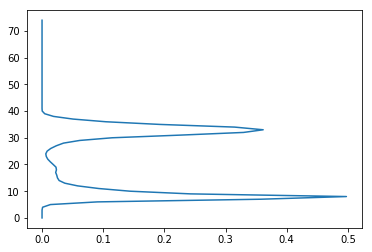

In [17]:
plt.plot(np.mean(cldfrac[8,], axis = (1,2)), range(75))



In [8]:
#cloud fraction
dp = '/home/users/arm33/RCEMIP/'+ model + '/processed_new'  

nd = nodays*ts

for temp in ['large305']:#temps:
    print('-----------' + temp + '----------')
    #calc 24 hour means of cloud condensate and sat mix ratio
    satmixr =np.empty((nodays, levsize,len(y_orig), len(x_orig) ))
    cloudcon = np.empty((nodays, levsize,len(y_orig), len(x_orig) ))
    datapath = '/badc/rcemip/data/'+ model +'/RCE_' + temp + '/3D/'
    for t in range(nodays):       
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_clw_last25d.nc')
        clw = np.mean(nc.variables['clw'][tbk[t,0]:tbk[t,-1]+1, ], axis = 0)
        nc.close()
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_cli_last25d.nc')
        cli = np.mean(nc.variables['cli'][tbk[t,0]:tbk[t,-1]+1, ], axis = 0)
        nc.close()
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_pa_last25d.nc')
        pa = np.mean(nc.variables['pa'][tbk[t,0]:tbk[t,-1]+1,], axis = 0)
        nc.close()
        pa = np.asarray(pa) * units.pascal
        nc = Dataset( datapath + model + '_RCE_' + temp + '_3D_ta_last25d.nc')
        ta = np.mean(nc.variables['ta'][tbk[t,0]:tbk[t,-1]+1,], axis =0)
        nc.close()
        ta = np.asarray(ta) * units.K
        satmixr[t, ] = metpy.calc.saturation_mixing_ratio(pa, ta)
        cloudcon[t,]= clw + cli
        

    #calc cloud frac
    cldfrac = np.zeros((nodays, levsize, ny, nx))
    for t in range(nodays):
        print(t)
        for k in range(levsize):
            for i in range(ny):
                if i == ny-1: # check if it's the last block, if yes then use all remaining gridpoints
                    endy = y_orig[-1]+1
                else:
                    endy = ybk[i,-1]+1
                for j in range(nx): # ditto
                    if j == nx-1:
                        endx = x_orig[-1]+1
                    else:
                        endx = xbk[j,-1]+1

                    cc = cloudcon[t,k, ybk[i,0]:endy, xbk[j,0]: endx].flatten()
                    sm = satmixr[t,k, ybk[i,0]:endy, xbk[j,0]: endx].flatten()
                    no_grid_points = len(sm)
                    count = 0
                    for r in range(no_grid_points):
                        if cc[r] > 0.00001:
                            count +=1
                        elif cc[r] > 0.01*sm[r]:
                            count +=1 

                    cldfrac[t,k, i , j ] = count/no_grid_points

    cldfrac.dump(dp + '/3D/'+ temp + 'cldfrac_profile_25d.npy')
    

-----------large305----------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
